# Using the PatentsView API to pull data about design patents granted by the USPTO applied for from 1980-2015

Associated data fields:
1. patent number
2. application data
3. USPC class at the subclass level

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
# def clean_dataframe(df):
#     """ Cleans dataframe created by PatentsView JSON object
        
#         Args:
#         df(dataframe): the datafame to be cleaned
        
#         Returns:
#         df(dataframe): the proccessed dataframe
#     """
    
    #filter to make sure mis-classified patents are not included
#     df = df[df.patent_number.str.contains('D')]

#     #extract application date and year
#     df['app_date'] = df['applications'].astype(str).str.extract('(\d{4}-\d{2}-\d{2})')
#     pd.to_datetime(df.app_date, errors='coerce')
#     df.drop('applications', axis=1, inplace=True)
    
#     df['app_date'] = pd.to_datetime(master_df['app_date'], errors='coerce')
#     df['year'] = master_df['app_date'].apply(lambda x: x.year)

# #     df['uspcs'] = df['uspcs'].astype(str).str.findall('(D\d{2}\/\d{3}|\d{3}\/\d{3})')
# #     holder = df.apply(lambda x: pd.Series(x['uspcs']),axis=1).stack().reset_index(level=1, drop=True)
# #     holder.name = 'class'
# #     df = df.drop('uspcs', axis=1).join(holder)
# #     df['mainclass'] = df['class'].str[0:3]
#     return df


In [3]:
def remove_non_design(df):
    #filter to make sure mis-classified patents are not included
    return df[df.patent_number.str.contains('D')]
    

In [4]:
def extract_date(df):
    #extract application date and year
    df['app_date'] = df['applications'].astype(str).str.extract('(\d{4}-\d{2}-\d{2})')
    pd.to_datetime(df.app_date, errors='coerce')
    df.drop('applications', axis=1, inplace=True)
    
    df['app_date'] = pd.to_datetime(master_df['app_date'], errors='coerce')
    df['year'] = master_df['app_date'].apply(lambda x: x.year)
    return df

In [5]:
def extract_class(df):
    #extract class information
    pattern = "([D0-9]\d{2}/\d{1,3}\.?\d{1,2})"

    df['uspcs'] = df['uspcs'].astype(str).str.findall(pattern)
    holder = df.apply(lambda x: pd.Series(x['uspcs']),axis=1).stack().reset_index(level=1, drop=True)
    holder.name = 'class'
    return master_df.drop('uspcs', axis=1).join(holder)

In [6]:
def mark_missing_citaitons(df):
    
    """ Marks patents that have missing citaiton data
        
        Args:
        df(dataframe): the datafame to be cleaned
        
        Returns:
        df(dataframe): the proccessed dataframe with additional columns is_missing(boolean) and num_missing(int)
    """
    
    
    df['num_cited_returned'] = df['cited_patents'].astype(str).str.findall('(\d{7}|D\d{6})').apply(lambda x: len(x))
    df['patent_num_us_patent_citations'] = df['patent_num_us_patent_citations'].astype(np.int64)
    df['num_missing'] = df['patent_num_us_patent_citations'].sub(df['num_cited_returned'])
    df['is_missing'] = np.where(df['num_missing'] >0, 1, 0)
    
    return df
    

In [7]:
# building the query dynamically
base_url = "http://www.patentsview.org/api/patents/query?"
field_list = "&f=[\"patent_number\",\"app_date\",\"uspc_subclass_id\",\"cited_patent_number\",\"patent_num_us_patent_citations\"]"

master_df = pd.DataFrame()

In [8]:
#Due to the limits of the amount of results the API can return, query must be performed in loop by date and page

for year in range(1980,2016):
    page = 1
    more_patents = True
    
    while more_patents:
        
        query = "q={{\"_and\":[{{\"patent_type\":\"Design\"}},{{\"_gte\":{{\"app_date\":\"{0}-01-01\"}}}},{{\"_lte\":{{\"app_date\":\"{0}-12-31\"}}}}]}}".format(year)
        options = "&o={{\"per_page\":10000,\"page\":{}}}".format(page)

        full_url = base_url + query + field_list + options
        r = requests.get(full_url)
        data = r.json()
        print(year,"-",page,"-",data['count'])

        df = pd.io.json.json_normalize(data['patents'])
        master_df = pd.concat([master_df, df], ignore_index=True)

        
        # decide if to continue to next year or next page
        if data['count'] < 10000:
            more_patents = False
        else:
            page += 1
            
      


1980 - 1 - 5034
1981 - 1 - 4807
1982 - 1 - 5216
1983 - 1 - 5495
1984 - 1 - 6020
1985 - 1 - 6506
1986 - 1 - 6337
1987 - 1 - 6950
1988 - 1 - 7409
1989 - 1 - 7581
1990 - 1 - 8388
1991 - 1 - 8533
1992 - 1 - 8722
1993 - 1 - 9296
1994 - 1 - 10000
1994 - 2 - 932
1995 - 1 - 10000
1995 - 2 - 1779
1996 - 1 - 10000
1996 - 2 - 2402
1997 - 1 - 10000
1997 - 2 - 3494
1998 - 1 - 10000
1998 - 2 - 4274
1999 - 1 - 10000
1999 - 2 - 4990
2000 - 1 - 10000
2000 - 2 - 5837
2001 - 1 - 10000
2001 - 2 - 5589
2002 - 1 - 10000
2002 - 2 - 7202
2003 - 1 - 10000
2003 - 2 - 8665
2004 - 1 - 10000
2004 - 2 - 9673
2005 - 1 - 10000
2005 - 2 - 10000
2005 - 3 - 966
2006 - 1 - 10000
2006 - 2 - 10000
2006 - 3 - 471
2007 - 1 - 10000
2007 - 2 - 10000
2007 - 3 - 1711
2008 - 1 - 10000
2008 - 2 - 10000
2008 - 3 - 1459
2009 - 1 - 10000
2009 - 2 - 10000
2009 - 3 - 863
2010 - 1 - 10000
2010 - 2 - 10000
2010 - 3 - 3437
2011 - 1 - 10000
2011 - 2 - 10000
2011 - 3 - 4647
2012 - 1 - 10000
2012 - 2 - 10000
2012 - 3 - 6286
2013 - 1 - 10000


In [9]:
# master_df.isnull().sum()

In [10]:
# master_df.dropna(inplace=True) # removing data poins where the classification data is null, since its not useful.
#most of the data null data is from 2015, so this might improve with time.
# master_df.to_csv('USDesign.csv',index=False)

# How much citation data is missing?

In [11]:
master_df = remove_non_design(master_df)
master_df = extract_date(master_df)
master_df = extract_class(master_df)
master_df = mark_missing_citaitons(master_df)

/home/tiera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:

(master_df[master_df['num_missing'] >0].shape[0]/master_df.shape[0]) *100

58.76622710772954

Approx 54.926% of citation data is missing. This is mostly due to citing patents that were granted before 1976, which is the yeat that patentViews beings coverage.

Let's break it down by year

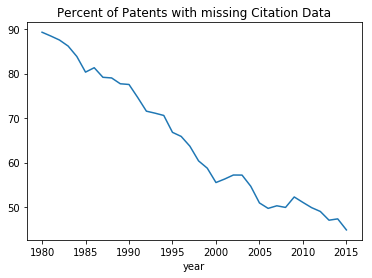

In [13]:

master_df.groupby(['year']).apply((lambda x: (x[x['num_missing'] > 0].shape[0]/ x.shape[0])*100)).plot(title="Percent of Patents with missing Citation Data")

In [14]:
keep = master_df

In [15]:
# pattern = "([D0-9]\d{2}/\d{1,3}\.?\d{1,2})"

# master_df['uspcs'] = master_df['uspcs'].astype(str).str.findall(pattern)
# holder = master_df.apply(lambda x: pd.Series(x['uspcs']),axis=1).stack().reset_index(level=1, drop=True)
# holder.name = 'class'
# master_df = master_df.drop('uspcs', axis=1).join(holder)

In [23]:
pattern = "([D0-9]\d{6})"

In [24]:
master_df['test'] = master_df['cited_patents'].astype(str).str.findall(pattern)

In [25]:
master_df

,cited_patents,patent_num_us_patent_citations,patent_number,app_date,year,class,num_cited_returned,num_missing,is_missing,test
0,"[{'cited_patent_number': None}, {'cited_patent...",5,D257752,1980-01-14,1980,D19/75,1,4,1,[4162014]
1,"[{'cited_patent_number': None}, {'cited_patent...",5,D257924,1980-01-14,1980,D06/573,1,4,1,[4162014]
2,"[{'cited_patent_number': None}, {'cited_patent...",10,D258382,1980-01-17,1980,D23/214,1,9,1,[D253842]
3,"[{'cited_patent_number': None}, {'cited_patent...",10,D258383,1980-01-17,1980,D23/214,1,9,1,[D253842]
4,[{'cited_patent_number': None}],4,D258571,1980-04-03,1980,D09/560,0,4,1,[]
5,[{'cited_patent_number': None}],2,D258650,1980-06-09,1980,D12/410,0,2,1,[]
6,"[{'cited_patent_number': None}, {'cited_patent...",10,D258678,1980-01-17,1980,D23/214,1,9,1,[D253842]
7,"[{'cited_patent_number': None}, {'cited_patent...",10,D258755,1980-04-01,1980,D23/214,1,9,1,[D253842]
8,[{'cited_patent_number': None}],7,D258760,1980-02-28,1980,D23/225,0,7,1,[]
9,"[{'cited_patent_number': None}, {'cited_patent...",20,D258766,1980-01-28,1980,D25/119,10,10,1,"[3939620, 3955331, 3971178, 4021980, 4068428, ..."
